## Step 0: Jupyter Notebook Setup and Additional Data Cleanup/Setting

In [26]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
import random

In [129]:
# plots linear regression line and returns pearson correlation
def plot_linregress(x_values, y_values, x_label, y_label, scatter_color):
    plt.scatter(x_values, y_values, color=scatter_color)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    plt.plot(x_values,regress_values,"r-", alpha=0.7)
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.annotate(line_eq, (min(x_values), min(y_values)),fontsize=18,color="red", alpha=0.7)
    return abs(st.pearsonr(x_values, y_values)[0])

# adds dashed lines to show significane of each GAD threshold
def gad_annotations(x_values):
    # no anxiety
    plt.axhline(4, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('No anxiety', (max(x_values)*.85, 3.3), fontsize = 10, color='black', alpha=0.7)
    # mild anxiety
    plt.axhline(9, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Mild anxiety', (max(x_values)*.85, 8.3), fontsize = 10, color='black', alpha=0.7)
    # moderate anxiety
    plt.axhline(14, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Moderate anxiety', (max(x_values)*.85, 13.3), fontsize = 10, color='black', alpha=0.7)
    # severe anxiety
    plt.axhline(21, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Severe anxiety', (max(x_values)*.85, 20.3), fontsize = 10, color='black', alpha=0.7)

# adds dashed lines to show significane of each SWL threshold
def swl_annotations(x_values):
    # extremely dissatisfied
    plt.axhline(9, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Extremely dissatisfied', (max(x_values)*.8, 7.9), fontsize = 10, color='black', alpha=0.7)
    # dissatisfied
    plt.axhline(14, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Dissatisfied', (max(x_values)*.8, 12.9), fontsize = 10, color='black', alpha=0.7)
    # slightly dissatisfied
    plt.axhline(19, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Slightly dissatisfied', (max(x_values)*.8, 17.9), fontsize = 10, color='black', alpha=0.7)
    # neutral
    plt.axhline(20, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Neutral', (max(x_values)*.8, 20.5), fontsize = 10, color='black', alpha=0.7)
    # Slightly satisfied
    plt.axhline(25, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Slightly satisfied', (max(x_values)*.8, 23.9), fontsize = 10, color='black', alpha=0.7)
    # Satisfied
    plt.axhline(30, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Satisfied', (max(x_values)*.8, 28.9), fontsize = 10, color='black', alpha=0.7)
    # Extremely satisfied
    plt.axhline(35, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Extremely satisfied', (max(x_values)*.8, 33.9), fontsize = 10, color='black', alpha=0.7)

# adds dashed lines to show significane of each SPIN threshold
def spin_annotations(x_values):
    # no social anxiety
    plt.axhline(20, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('No social anxiety', (max(x_values)*.82, 17.5), fontsize = 10, color='black', alpha=0.7)
    # mild anxiety
    plt.axhline(30, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Mild anxiety', (max(x_values)*.82, 27.5), fontsize = 10, color='black', alpha=0.7)
    # moderate anxiety
    plt.axhline(40, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Moderate anxiety', (max(x_values)*.82, 37.5), fontsize = 10, color='black', alpha=0.7)
    # severe anxiety
    plt.axhline(50, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Severe anxiety', (max(x_values)*.82, 47.5), fontsize = 10, color='black', alpha=0.7)
    # very severe anxiety
    plt.axhline(68, color='black', alpha = 0.5, linestyle='dashed')
    plt.annotate('Very severe anxiety', (max(x_values)*.82, 65.5), fontsize = 10, color='black', alpha=0.7)


In [28]:
# import data
gaming_data = pd.read_csv('data_cleanup/Gaming.csv', encoding='UTF-8')


In [29]:
# trim data
gaming_data = gaming_data[['Entry', 'Gender', 'Age', 'Game', 'Hours per Week', 
            'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'GAD Total', 
            'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'SWL Total',
            'SPIN1', 'SPIN2', 'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8',
            'SPIN9', 'SPIN10', 'SPIN11', 'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15',
            'SPIN16', 'SPIN17', 'SPIN Total']]

gaming_data.head()

,Entry,Gender,Age,Game,Hours per Week,GAD1,GAD2,GAD3,GAD4,GAD5,...,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,SPIN Total
0,1,Male,25,Skyrim,15,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,5
1,2,Male,41,Other,8,1,2,2,2,0,...,4,0,3,0,1,3,3,1,2,33
2,3,Female,32,Other,0,0,2,2,0,0,...,0,1,1,3,0,2,4,4,2,31
3,4,Male,28,Other,20,0,0,0,0,0,...,0,0,1,3,0,0,1,0,0,11
4,5,Male,19,Other,20,2,1,2,2,2,...,2,0,1,0,0,0,0,3,0,13


In [30]:
# Categorize games
gaming_data['Category'] = ''
for index, row in gaming_data.iterrows():
    switch={
        'League of Legends': 'MOBA', 
        'Other': 'N/A', 
        'Starcraft 2' : 'RTS', 
        'Counter Strike':'FPS',
        'World of Warcraft':'MMORPG', 
        'Hearthstone':'CCG', 
        'Diablo 3':'RPG', 
        'Heroes of the Storm':'MOBA',
        'Guild Wars 2':'MMORPG', 
        'Skyrim':'RPG', 
        'Destiny':'FPS'
    }
    gaming_data.loc[index, 'Category'] = switch.get(gaming_data.loc[index, 'Game'])

In [31]:
# Create age bins
bins = [18, 21, 25, 30, 60]

# Create labels for said bins
group_labels = ["18 to 21", "22 to 25", "26 to 30", "31 to 60"]

# Bin the data
gaming_data["Age Group"] = pd.cut(gaming_data["Age"], bins, labels=group_labels)


In [32]:
# Reorganize DataFrame
gaming_data = gaming_data[['Entry', 'Gender', 'Age Group', 'Age', 'Game', 'Category', 'Hours per Week', 
            'GAD1', 'GAD2', 'GAD3', 'GAD4', 'GAD5', 'GAD6', 'GAD7', 'GAD Total', 
            'SWL1', 'SWL2', 'SWL3', 'SWL4', 'SWL5', 'SWL Total',
            'SPIN1', 'SPIN2', 'SPIN3', 'SPIN4', 'SPIN5', 'SPIN6', 'SPIN7', 'SPIN8',
            'SPIN9', 'SPIN10', 'SPIN11', 'SPIN12', 'SPIN13', 'SPIN14', 'SPIN15',
            'SPIN16', 'SPIN17', 'SPIN Total']]
gaming_data

,Entry,Gender,Age Group,Age,Game,Category,Hours per Week,GAD1,GAD2,GAD3,...,SPIN9,SPIN10,SPIN11,SPIN12,SPIN13,SPIN14,SPIN15,SPIN16,SPIN17,SPIN Total
0,1,Male,22 to 25,25,Skyrim,RPG,15,0,0,0,...,0,0,0,0,0,1,0,1,0,5
1,2,Male,31 to 60,41,Other,N/A,8,1,2,2,...,4,0,3,0,1,3,3,1,2,33
2,3,Female,31 to 60,32,Other,N/A,0,0,2,2,...,0,1,1,3,0,2,4,4,2,31
3,4,Male,26 to 30,28,Other,N/A,20,0,0,0,...,0,0,1,3,0,0,1,0,0,11
4,5,Male,18 to 21,19,Other,N/A,20,2,1,2,...,2,0,1,0,0,0,0,3,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11133,14246,Male,22 to 25,22,Other,N/A,40,1,0,0,...,0,0,0,0,0,0,1,0,0,7
11134,14247,Female,18 to 21,20,League of Legends,MOBA,20,3,3,3,...,2,1,4,0,2,2,1,0,1,25
11135,14248,Male,18 to 21,19,Starcraft 2,RTS,20,0,0,0,...,0,1,1,1,0,1,0,0,0,10
11136,14249,Female,NaN,18,Other,N/A,5,3,2,1,...,4,1,3,1,0,3,2,0,1,32


## Step 0.5: Terminology and Hypotheses

Terminology:
- GAD-7 is the Generalized Anxiety Disorder survey used as an initial screening tool for generalized anxiety disorder. Each item is statement where scored from 0-3. with 0 being little to no anxiety, 3 being the most anxious.
    - Anxiety severity scale: (https://patient.info/doctor/generalised-anxiety-disorder-assessment-gad-7)
        - 0-4: No anxiety
        - 5-9: Mild anxiety
        - 10-14: Moderate anxiety
        - 15-21: Severe anxiety
- SWL is the Satisfaction with Life Scale. Each item is statement scored from 1-7. 1 being unsatisfied, 7 being ideal.
    - SWL Scale: https://positivepsychology.com/life-satisfaction-scales/
        - 31–35 = Extremely satisfied
        - 26–30 = Satisfied
        - 21–25 = Slightly satisfied
        - 20 = Neutral
        - 15–19 = Slightly dissatisfied
        - 10–14 = Dissatisfied
        - 5–9 = Extremely dissatisfied
- SPIN is the Social Phobia Inventory. Each item is a statement scored from 0-4. 0 being unbothered, 4 being most bothered.
    - SPIN Scale: (https://www.verywellhealth.com/social-phobia-inventory-test-5271967)
        - No social anxiety (0-20)
        - Mild (21-30)
        - Moderate (31-40)
        - Severe (41-50)
        - Very severe (51-68)

### Question 1: Do League players suffer more proportionately from GAD/Social Phobia than people playing other games? How about life satisfaction?
- Hypotheses: League players more likely than not have 

In [33]:
# split data into League gamers v. Non-League gamers
league_data = gaming_data[gaming_data['Game'] == 'League of Legends']
not_league_data = gaming_data[gaming_data['Game'] != 'League of Legends']
# check if these values are normally distributed
swl_league_norm = st.normaltest(league_data['SWL Total'].sample(200))
swl_nleague_norm = st.normaltest(not_league_data['SWL Total'].sample(200))
gad_league_norm = st.normaltest(league_data['GAD Total'].sample(200))
gad_nleague_norm = st.normaltest(not_league_data['GAD Total'].sample(200))
spin_league_norm = st.normaltest(league_data['SPIN Total'].sample(200))
spin_nleague_norm = st.normaltest(not_league_data['SPIN Total'].sample(200))
# when using normaltest, the data returned is 1) chi-squared statistic and 2) p-value. 
# in this case, a p-value of <5% means that there is a <5% (or >95%) chance that  
#   the data did not come from a normal distribution
# --------- SWL Scores ---------
if swl_league_norm.pvalue < .05:
    print (f'league_data is not normally distributed: {swl_league_norm}')
if swl_nleague_norm.pvalue < .05:
    print (f'not_league_data is not normally distributed: {swl_nleague_norm}')
# --------- GAD Scores ---------
if gad_league_norm.pvalue < .05:
    print (f'league_data is not normally distributed: {gad_league_norm}')
if gad_nleague_norm.pvalue < .05:
    print (f'not_league_data is not normally distributed: {gad_nleague_norm}')
# --------- SPIN Scores ---------
if spin_league_norm.pvalue < .05:
    print (f'league_data is not normally distributed: {spin_league_norm}')
if spin_nleague_norm.pvalue < .05:
    print (f'not_league_data is not normally distributed: {spin_nleague_norm}')

league_data is not normally distributed: NormaltestResult(statistic=13.10917811225013, pvalue=0.0014235677532672606)
not_league_data is not normally distributed: NormaltestResult(statistic=28.515075926701797, pvalue=6.427320208946363e-07)
league_data is not normally distributed: NormaltestResult(statistic=46.7142571890427, pvalue=7.180057765867065e-11)
not_league_data is not normally distributed: NormaltestResult(statistic=52.608257494506724, pvalue=3.769311537271406e-12)
league_data is not normally distributed: NormaltestResult(statistic=21.296779009322545, pvalue=2.3739042445555972e-05)
not_league_data is not normally distributed: NormaltestResult(statistic=16.599055890101656, pvalue=0.0002486341683997307)


In [34]:
# check what % of data
league_pct = (len(league_data['SWL Total']) / len(gaming_data['SWL Total'])) * 100
print(f'League players comprise {round(league_pct,2)}% of the data.')

League players comprise 83.73% of the data.


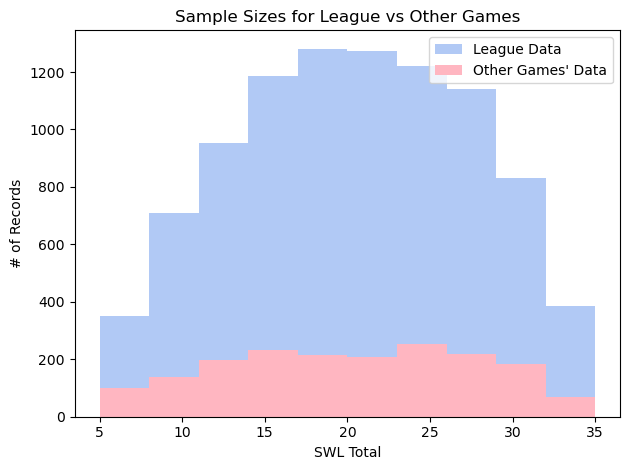

In [149]:
# visual confirmation that the data is not normally distributed (SWL Only)
plt.hist(league_data['SWL Total'], alpha=0.5, label='League Data', color='cornflowerblue')
plt.hist(not_league_data['SWL Total'], label="Other Games' Data", color='lightpink')
plt.xlabel('SWL Total')
plt.ylabel('# of Records')
plt.legend(loc='best')
plt.title('Sample Sizes for League vs Other Games')
plt.tight_layout()

plt.savefig('images/SWL_SampleSizes_for_League_v_Other')

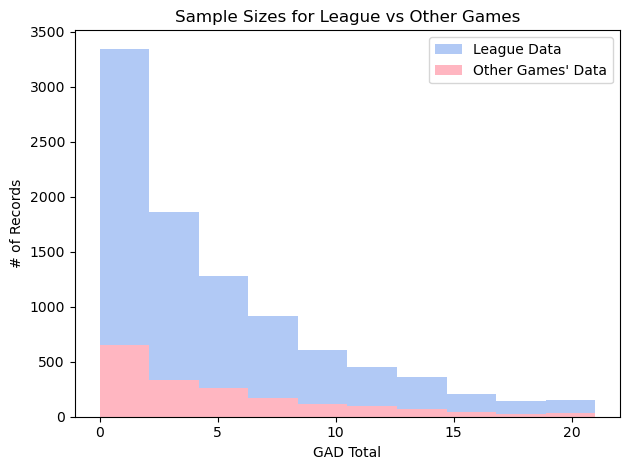

In [150]:
# visual confirmation that the data is not normally distributed (GAD Only)
plt.hist(league_data['GAD Total'], alpha=0.5, label='League Data', color='cornflowerblue')
plt.hist(not_league_data['GAD Total'], label="Other Games' Data", color='lightpink')
plt.xlabel('GAD Total')
plt.ylabel('# of Records')
plt.legend(loc='best')
plt.title('Sample Sizes for League vs Other Games')
plt.tight_layout()

plt.savefig('images/GAD_SampleSizes_for_League_v_Other')

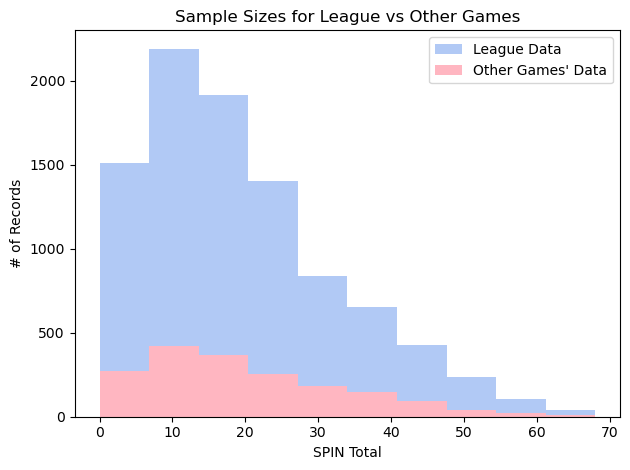

In [151]:
# visual confirmation that the data is not normally distributed (GAD Only)
plt.hist(league_data['SPIN Total'], alpha=0.5, label='League Data', color='cornflowerblue')
plt.hist(not_league_data['SPIN Total'], label="Other Games' Data", color='lightpink')
plt.xlabel('SPIN Total')
plt.ylabel('# of Records')
plt.legend(loc='best')
plt.title('Sample Sizes for League vs Other Games')
plt.tight_layout()

plt.savefig('images/SPIN_SampleSizes_for_League_v_Other')

In [ ]:
# Create Box Plot to understand data distribution within each age group for league players

# create list of age groups to plot boxplot against
age_groups = group_labels

# create empty list to store SWL Totals (per age group) for plotting
swl_totals = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for age_group in age_groups:
    # create current_group var for all rows under current age group
    current_group = league_data['Age Group'] == age_group
    age_group_data = league_data[current_group]
    # create quartiles and standard quartile calculations based on current age group's SWL Totals 
    quartiles = age_group_data['SWL Total'].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    # Locate the rows which contain each age group and get SWL totals
    curr_swl_totals = league_data.loc[current_group, 'SWL Total']
    # add subset. each Series item in swl_totals corresponds to the same index in treatments
    swl_totals.append(curr_swl_totals)
    # Determine outliers using upper and lower bounds
    # outliers are values that are either below lower_bound or above upper_bound
    outliers = [val for val in curr_swl_totals if (val > upper_bound) or (val < lower_bound)]
    print(f"{age_group}'s potential outliers: {outliers}")

# Generate a box plot that shows the distribution of the tumor volume for each treatment group.
fig1, ax1 = plt.subplots()
ax1.set_ylabel('SWL Totals')
# flierprops changes properties of the "fliers" or outliers
ax1.boxplot(swl_totals, flierprops={'markersize': 12, 'markerfacecolor': 'red'})
ax1.set_xticks(range(1, len(age_groups)+1), age_groups);

In [133]:
# calculate T-Test of league player scores v not_league player scores
swl_lol_ttest = st.ttest_ind(league_data['SWL Total'], not_league_data['SWL Total'])
gad_lol_ttest = st.ttest_ind(league_data['GAD Total'], not_league_data['GAD Total'])
spin_lol_ttest = st.ttest_ind(league_data['SPIN Total'], not_league_data['SPIN Total'])
print('The statistical significance values (p-values) between League and Non-League Players are:')
print(f'\tSWL p-value: {round(swl_lol_ttest.pvalue, 2)}')
print(f'\tGAD p-value: {round(gad_lol_ttest.pvalue, 2)}')
print(f'\tSPIN p-value: {round(spin_lol_ttest.pvalue, 2)}')
print('Because the p-values for each of the tests are greater than 0.5, \nwe cannot reject the null hypothesis that there is no difference between these two populations.')

The statistical significance values (p-values) between League and Non-League Players are:
	SWL p-value: 0.28
	GAD p-value: 0.48
	SPIN p-value: 0.09
Because the p-values for each of the tests are greater than 0.5, 
we cannot reject the null hypothesis that there is no difference between these two populations.


## Hypothesis 2: Is there any correlation between ages of gamers and their psychological scores? Do older players tend to have lower Generalized Anxiety or Social Phobia? Are older players more satisfied with life?

In [126]:
# create x_age sample for plotting the various tests
sample_size = 100
sample_age = gaming_data.sample(sample_size)
x_age = sample_age['Age'].sample(sample_size)

Pearson correlation coefficient is 0.14


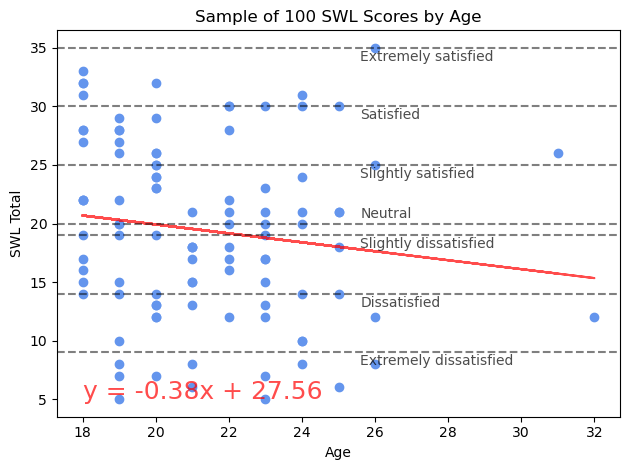

In [135]:
# plot sample of 
# SWL Totals v Age
swl_y_age = sample_age['SWL Total']
pears = plot_linregress(x_age, swl_y_age, 'Age', 'SWL Total', 'cornflowerblue')
swl_annotations(x_age)
plt.title(f'Sample of {sample_size} SWL Scores by Age')
plt.tight_layout()
print(f'Pearson correlation coefficient is {abs(round(pears,2))}')

plt.savefig('images/Sample_SWL_by_Age')

Pearson correlation coefficient is 0.02


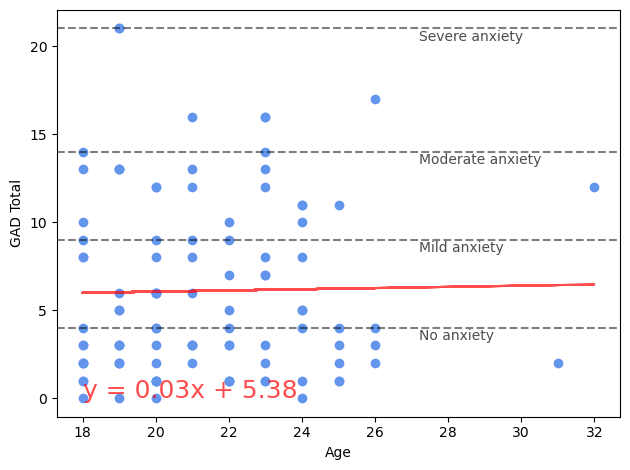

In [136]:
# GAD Totals v Age
gad_y_age = sample_age['GAD Total']
pears = plot_linregress(x_age, gad_y_age, 'Age', 'GAD Total', 'cornflowerblue')
gad_annotations(x_age)
plt.tight_layout()
print(f'Pearson correlation coefficient is {abs(round(pears,2))}')

plt.savefig('images/Sample_GAD_by_Age')

Pearson correlation coefficient is 0.04


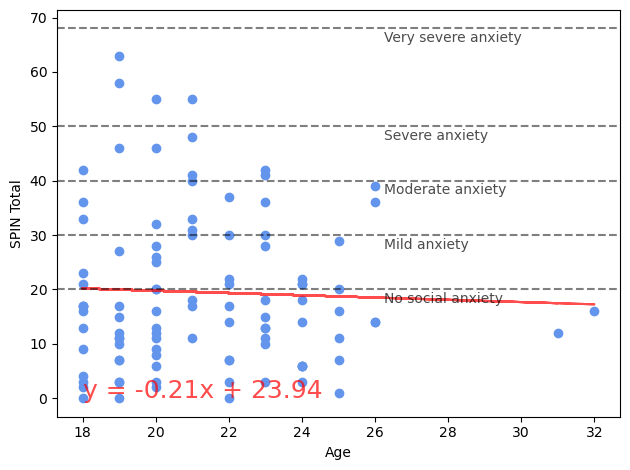

In [138]:
# SPIN Totals v Age
spin_y_age = sample_age['SPIN Total']
pears = plot_linregress(x_age, spin_y_age, 'Age', 'SPIN Total', 'cornflowerblue')
spin_annotations(x_age)
plt.tight_layout()
print(f'Pearson correlation coefficient is {abs(round(pears,2))}')

plt.savefig('images/Sample_SPIN_by_Age')

In [41]:
# create aggregate table of ages v test scores
age_summary = gaming_data.groupby('Age')[['SWL Total', 'GAD Total', 'SPIN Total']]
agg_age = age_summary.agg(['mean', 'median', 'var', 'std', 'sem'])
agg_age

SWL Total                                          GAD Total         \
          mean median         var        std       sem       mean median   
Age                                                                        
18   20.359375   21.0   48.178519   6.941075  0.146657   5.376786    4.0   
19   19.899351   20.0   48.983909   6.998851  0.162808   5.031926    4.0   
20   19.349062   19.0   49.042125   7.003008  0.172246   5.293406    4.0   
21   19.588538   20.0   51.501163   7.176431  0.194527   5.379868    4.0   
22   19.413397   19.0   54.924725   7.411122  0.229259   5.414354    4.0   
23   19.568773   20.0   54.320016   7.370211  0.259444   5.130112    4.0   
24   19.585284   19.0   52.487689   7.244839  0.296263   4.819398    3.0   
25   19.382413   19.0   60.085018   7.751453  0.350533   4.840491    3.0   
26   19.187500   19.0   51.833072   7.199519  0.402465   4.771875    4.0   
27   21.041667   21.0   58.626163   7.656772  0.520977   4.296296    3.0   
28   20.234483   20.0   59.819636   7.734315  0.642300   5.006897    3.0   
29   21.477064   23.0   64.974006   8.060646  0.772070   4.935780    3.0   
30   21.152941   21.0   60.250140   7.762096  0.841918   4.270588    3.0   
31   22.800000   23.0   52.755556   7.263302  0.979383   4.127273    3.0   
32   19.627451   20.0   78.038431   8.833936  1.236999   5.490196    3.0   
33   22.222222   23.5   51.949206   7.207580  1.201263   3.444444    2.5   
34   23.315789   24.0   40.450292   6.360054  1.459097   3.315789    3.0   
35   23.714286   25.5   36.681319   6.056510  1.618671   3.714286    2.0   
36   23.750000   24.5   53.800000   7.334848  1.833712   5.500000    4.0   
37   22.750000   23.0   28.916667   5.377422  2.688711   2.750000    3.0   
38   21.285714   19.0   97.904762   9.894684  3.739839   4.142857    2.0   
39   13.833333   13.5   49.366667   7.026142  2.868410   3.833333    1.5   
40   12.500000   12.5   24.500000   4.949747  3.500000  13.000000   13.0   
41   20.750000   19.0  114.250000  10.688779  5.344390   4.500000    5.0   
42   25.000000   25.0    8.000000   2.828427  2.000000   3.000000    3.0   
44   21.000000   21.0  128.000000  11.313708  8.000000   0.500000    0.5   
49   19.000000   19.0         NaN        NaN       NaN   0.000000    0.0   
50   22.500000   22.5   84.500000   9.192388  6.500000   1.500000    1.5   
56   35.000000   35.0         NaN        NaN       NaN   0.000000    0.0   

                                   SPIN Total                                \
           var       std       sem       mean median         var        std   
Age                                                                           
18   22.393029  4.732127  0.099984  21.250000   19.0  185.273783  13.611531   
19   20.636230  4.542712  0.105673  20.659632   19.0  180.744401  13.444121   
20   21.902360  4.679996  0.115109  19.645493   17.0  177.013474  13.304641   
21   22.518094  4.745323  0.128628  19.925055   17.0  183.587026  13.549429   
22   22.486192  4.741961  0.146690  19.637321   17.0  183.511058  13.546625   
23   22.470643  4.740321  0.166867  18.407683   15.0  174.082968  13.194050   
24   22.004179  4.690861  0.191824  17.471572   14.0  163.167532  12.773705   
25   21.511390  4.638037  0.209739  17.431493   15.0  165.602367  12.868658   
26   18.490116  4.300013  0.240378  17.350000   14.0  161.200000  12.696456   
27   21.474591  4.634069  0.315308  17.337963   15.0  161.127110  12.693585   
28   27.770785  5.269799  0.437633  14.682759   12.0  140.801437  11.865978   
29   23.708801  4.869168  0.466382  17.889908   14.0  212.339619  14.571878   
30   18.271148  4.274476  0.463632  14.658824   13.0  124.322689  11.150008   
31   18.594613  4.312147  0.581450  16.345455   12.0  178.415488  13.357226   
32   37.734902  6.142874  0.860174  18.666667   14.0  222.826667  14.927380   
33   14.368254  3.790548  0.631758  13.666667   12.0  122.457143  11.066036   
34    8.228070  2.868461  0.658070  14.210526   11.0  118.175439  10.87

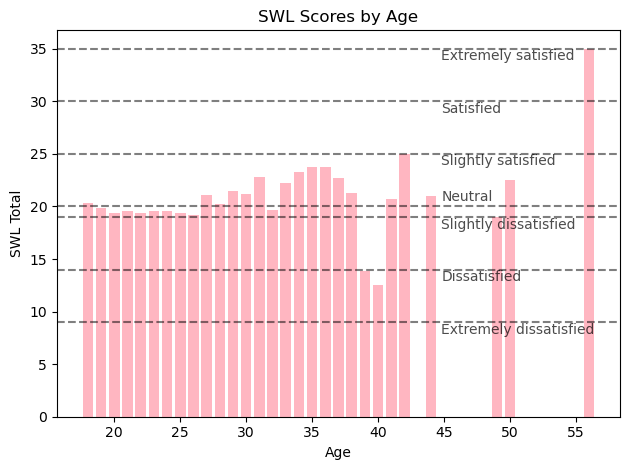

In [146]:
# plot SWL scores by age
x_values = agg_age.index
y_values = agg_age['SWL Total']['mean']
plt.bar(x_values, y_values, color='lightpink')
swl_annotations(x_values)
plt.xlabel('Age')
plt.ylabel('SWL Total')
plt.title('SWL Scores by Age')
plt.tight_layout()

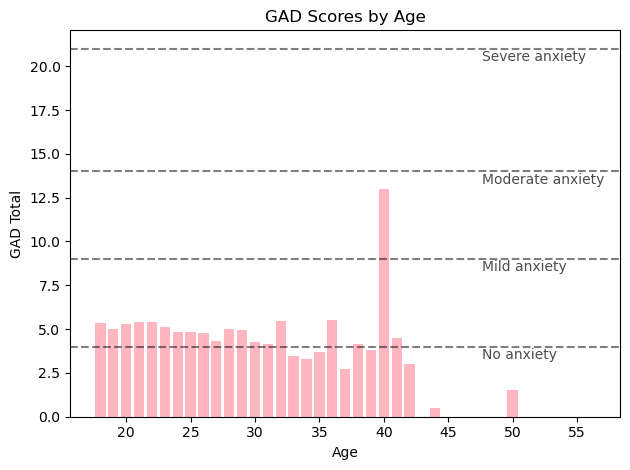

In [147]:
# plot GAD scores by age
x_values = agg_age.index
y_values = agg_age['GAD Total']['mean']
plt.bar(agg_age.index, agg_age['GAD Total']['mean'], color='lightpink')
gad_annotations(x_values)
plt.xlabel('Age')
plt.ylabel('GAD Total')
plt.title('GAD Scores by Age')
plt.tight_layout()

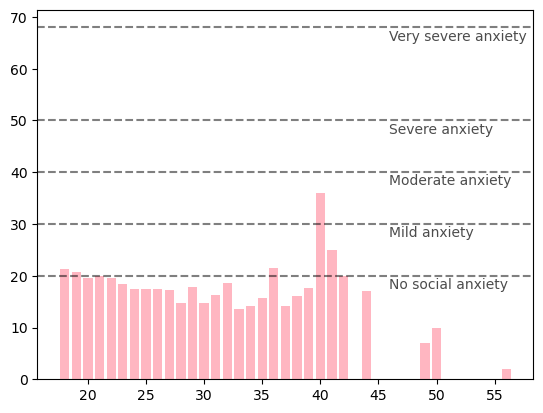

In [148]:
# plot SPIN scores by age
x_values = agg_age.index
y_values = agg_age['SPIN Total']['mean']
plt.bar(agg_age.index, agg_age['SPIN Total']['mean'], color='lightpink')
spin_annotations(x_values)

### Auxiliary Graphs/Exploration

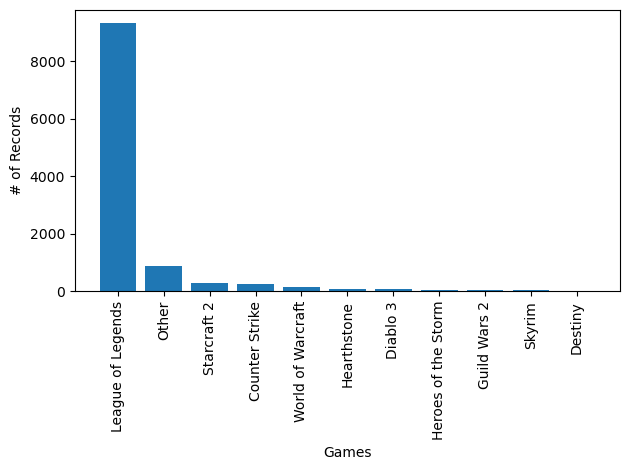

In [45]:
# show game data skew
games_only = gaming_data['Game'].value_counts()
# plot games data to visualize. chose 
plt.bar(games_only.index, games_only)
plt.ylabel('# of Records')
plt.xlabel('Games')
plt.xticks(rotation=90)
plt.tight_layout()

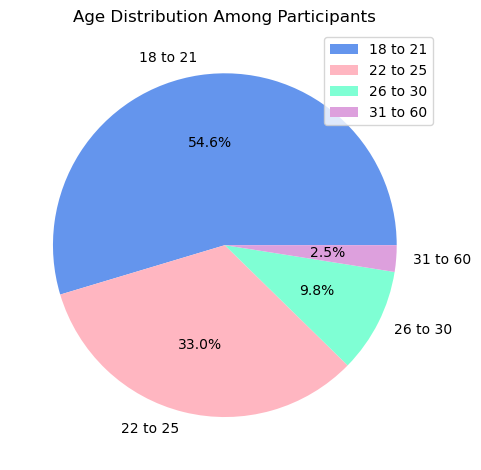

In [86]:
# show age data skew
age_only = gaming_data['Age Group'].value_counts()
# try pie chart
plt.pie(age_only, labels=age_only.index, autopct='%.1f%%', colors=['cornflowerblue','lightpink','aquamarine','plum'])
plt.legend(loc='best')
plt.title('Age Distribution Among Participants')
plt.tight_layout()

# the following cells will not be used for the project presentation/submission, but left for historical purposes/further exploration if so desired

## Hypothesis 3: Do RPG players suffer more proportionately from GAD or Social Phobia than players from other games? Is their life satisfaction higher as well?

In [219]:
# look at general anxiety and social phobia scores for RPG games
rpg_data = gaming_data[gaming_data['Category'].isin(['RPG', 'MMORPG'])]
not_rpg_data = gaming_data[~gaming_data['Category'].isin(['RPG', 'MMORPG'])]
swl_rpg_summary = rpg_data.groupby('Age')[['GAD Total', 'SWL Total', 'SPIN Total']]
agg_psy_rpg = swl_rpg_summary.agg(['mean', 'median', 'var', 'std', 'sem'])
agg_psy_rpg

GAD Total                                        SWL Total         \
         mean median        var       std       sem       mean median   
Age                                                                     
18   5.625000    4.5  24.048387  4.903915  0.866898  21.125000   23.0   
19   7.034483    7.0  32.677340  5.716410  1.061511  17.310345   17.0   
20   4.682927    4.0  15.671951  3.958782  0.618258  20.073171   22.0   
21   5.918919    5.0  31.409910  5.604454  0.921367  19.135135   18.0   
22   5.137931    4.0  21.980296  4.688315  0.870598  20.862069   23.0   
23   3.740741    3.0  13.814815  3.716829  0.715304  16.518519   14.0   
24   5.769231    2.0  41.858974  6.469851  1.794414  17.384615   16.0   
25   5.285714    5.0  12.989011  3.604027  0.963217  18.857143   19.5   
26   5.900000    4.5  36.544444  6.045200  1.911660  19.200000   19.5   
27   4.333333    2.0  29.750000  5.454356  1.818119  18.666667   21.0   
28   4.285714    4.0  11.238095  3.352327  1.267060  20.571429   18.0   
29   9.750000    9.0   5.583333  2.362908  1.181454  10.250000    8.5   
30   4.333333    4.5  10.666667  3.265986  1.333333  19.000000   15.0   
32   6.500000    6.5  40.500000  6.363961  4.500000  18.500000   18.5   
33   3.000000    3.0   0.000000  0.000000  0.000000  29.000000   29.0   
36   3.000000    3.0        NaN       NaN       NaN  31.000000   31.0   
41   0.000000    0.0        NaN       NaN       NaN  35.000000   35.0   

                                      SPIN Total                     \
            var        std        sem       mean median         var   
Age                                                                   
18    64.758065   8.047240   1.422564  26.125000   22.5  257.403226   
19    49.007389   7.000528   1.299965  21.482759   22.0  167.044335   
20    50.919512   7.135791   1.114423  17.268293   14.0  135.851220   
21    66.231231   8.138257   1.337921  24.216216   23.0  195.007508   
22    61.837438   7.863678   1.460248  20.896552   19.0  192.524631   
23    56.566952   7.521100   1.447436  20.333333   19.0  114.538462   
24    64.589744   8.036774   2.229000  24.000000   18.0  205.000000   
25    46.439560   6.814658   1.821294  23.000000   22.0  139.384615   
26    76.177778   8.727988   2.760032  24.500000   20.5  258.722222   
27    39.000000   6.244998   2.081666  22.666667   22.0  206.500000   
28    53.952381   7.345228   2.776235  19.000000   13.0  179.000000   
29    29.583333   5.439056   2.719528  38.500000   37.0  134.333333   
30    78.400000   8.854377   3.614784  19.333333   16.0  215.066667   
32   312.500000  17.677670  12.500000  16.000000   16.0  200.000000   
33     8.000000   2.828427   2.000000  23.000000   23.0   98.000000   
36          NaN        NaN        NaN  25.000000   25.0         NaN   
41          NaN        NaN        NaN   0.000000    0.0         NaN   

                           
           std        sem  
Age                        
18   16.043791   2.836168  
19   12.924563   2.400031  
20   11.655523   1.820287  
21   13.964509   2.295751  
22   13.875325   2.576583  
23   10.702264   2.059652  
24   14.317821   3.971049  
25   11.806126   3.155320  
26   16.084844   5.086474  
27   14.370108   4.790036  
28   13.379088   5.056820  
29   11.590226   5.795113  
30   14.665151   5.987023  
32   14.142136  10.000000  
33    9.899495   7.000000  
36         NaN        NaN  
41         NaN        NaN

Pearson correlation is 0.5327722307000364
With the Pearson correlation coefficient being 0.53, the mean GAD scores has a moderate, negative correlated with age


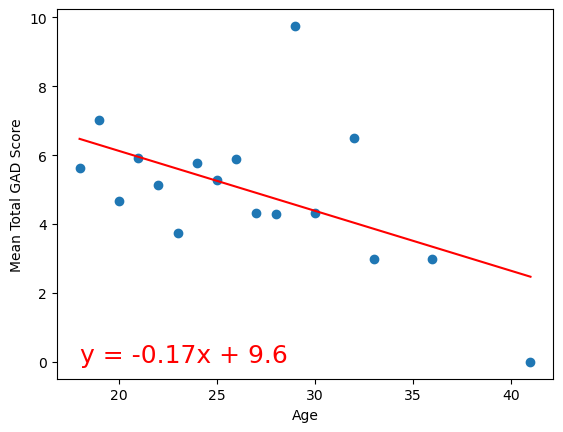

In [227]:
gad_regression = plot_linregress(agg_psy_rpg.index, agg_psy_rpg['GAD Total']['mean'],'Age', 'Mean Total GAD Score')
print(f'Pearson correlation is {gad_regression}')
print(f'With the Pearson correlation coefficient being {abs(round(gad_regression, 2))}, the mean GAD scores has a moderate, negative correlated with age')

Pearson correlation is 0.3984988046765676


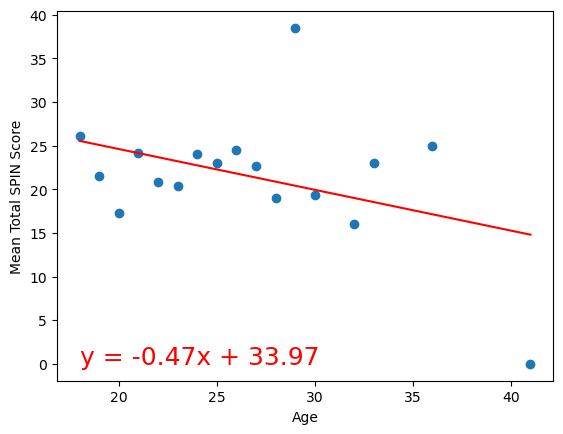

In [221]:
spin_regression = plot_linregress(agg_psy_rpg.index, agg_psy_rpg['SPIN Total']['mean'],'Age', 'Mean Total SPIN Score')
print(f'Pearson correlation is {spin_regression}')

In [222]:
# Run statistical test comparing GAD scores to SPIN scores for people who play RPG games vs people who don't
st.ttest_ind(rpg_data['GAD Total'], rpg_data['SPIN Total'])

TtestResult(statistic=-18.82260036929122, pvalue=8.323348302973293e-61, df=526.0)

In [223]:
# group gaming data by Category and aggregate the psychological tests
game_ctgy_data = gaming_data.groupby('Category')[['SWL Total', 'GAD Total', 'SPIN Total']]
agg_ctgy_data = game_ctgy_data.agg(['mean', 'median', 'var', 'std', 'sem'])
agg_ctgy_data

SWL Total                                       GAD Total         \
               mean median        var       std       sem      mean median   
Category                                                                     
CCG       20.068182   19.0  45.535528  6.748002  0.719339  5.954545    4.0   
FPS       18.899225   19.0  56.690194  7.529289  0.468753  5.031008    4.0   
MMORPG    19.144578   19.0  59.239576  7.696725  0.597382  5.102410    4.0   
MOBA      19.859904   20.0  51.243720  7.158472  0.073972  5.148318    4.0   
N/A       19.535260   19.0  53.885619  7.340682  0.249591  5.384971    4.0   
RPG       19.306122   19.5  64.111509  8.006966  0.808826  5.734694    4.0   
RTS       21.087248   22.0  52.975527  7.278429  0.421628  4.671141    4.0   

                                        SPIN Total                     \
                var       std       sem       mean median         var   
Category                                                                
CCG       27.653083  5.258620  0.560571  19.840909   19.0  141.100836   
FPS       21.127439  4.596459  0.286163  19.189922   16.0  187.835384   
MMORPG    21.619752  4.649704  0.360887  21.000000   19.0  175.612121   
MOBA      21.789512  4.667924  0.048236  19.490443   17.0  178.889406   
N/A       24.408339  4.940480  0.167981  20.443931   18.0  186.399920   
RPG       26.361877  5.134382  0.518651  23.683673   21.5  194.012308   
RTS       19.372969  4.401474  0.254971  17.963087   14.0  192.129946   

                               
                std       sem  
Category                       
CCG       11.878587  1.266262  
FPS       13.705305  0.853255  
MMORPG    13.251872  1.028545  
MOBA      13.374954  0.138210  
N/A       13.652836  0.464210  
RPG       13.928830  1.407024  
RTS       13.861095  0.802952

0.2834839408712678

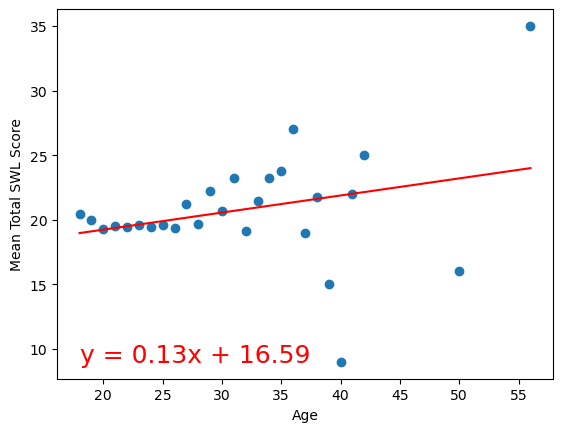

In [ ]:
# visualize average SWL Score for each age for league players
age_lol_summary = league_data.groupby('Age')['SWL Total']
agg_swl_lol = age_lol_summary.agg(['mean', 'median', 'var', 'std', 'sem'])
correl = plot_linregress(agg_swl_lol.index, agg_swl_lol['mean'],'Age', 'Mean Total SWL Score')
print(f'')

Text(0, 0.5, 'Mean SWL Total')

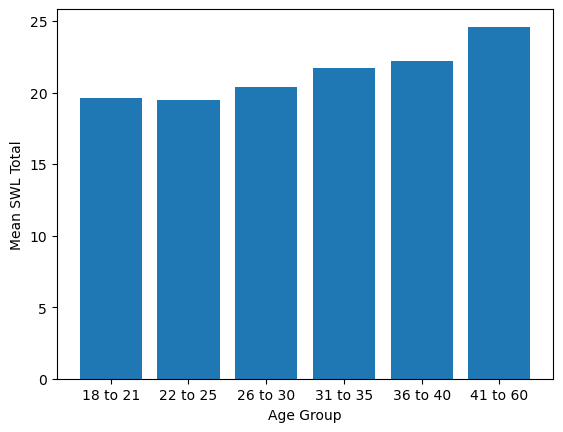

In [ ]:
# visualize average SWL Score for each age group for league players
age_group_lol_summary = league_data.groupby('Age Group', observed=True)[['SWL Total', 'GAD Total', 'SPIN Total']]
agg_swl_lol = age_group_lol_summary.agg(['mean', 'median', 'var', 'std', 'sem'])
plt.bar(agg_swl_lol.index, agg_swl_lol['SWL Total']['mean'])
plt.xlabel('Age Group')
plt.ylabel('Mean SWL Total')

18 to 21's potential outliers: []
22 to 25's potential outliers: []
26 to 30's potential outliers: []
31 to 35's potential outliers: []
36 to 40's potential outliers: []
41 to 60's potential outliers: [35]


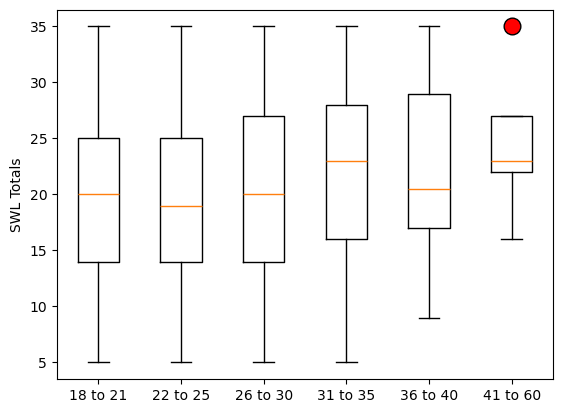

In [20]:
# Create Box Plot to understand data distribution within each age group for league players

# create list of age groups to plot boxplot against
age_groups = group_labels

# create empty list to store SWL Totals (per age group) for plotting
swl_totals = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
for age_group in age_groups:
    # create current_group var for all rows under current age group
    current_group = league_data['Age Group'] == age_group
    age_group_data = league_data[current_group]
    # create quartiles and standard quartile calculations based on current age group's SWL Totals 
    quartiles = age_group_data['SWL Total'].quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    # Locate the rows which contain each age group and get SWL totals
    curr_swl_totals = league_data.loc[current_group, 'SWL Total']
    # add subset. each Series item in swl_totals corresponds to the same index in treatments
    swl_totals.append(curr_swl_totals)
    # Determine outliers using upper and lower bounds
    # outliers are values that are either below lower_bound or above upper_bound
    outliers = [val for val in curr_swl_totals if (val > upper_bound) or (val < lower_bound)]
    print(f"{age_group}'s potential outliers: {outliers}")

# Generate a box plot that shows the distribution of the tumor volume for each treatment group.
fig1, ax1 = plt.subplots()
ax1.set_ylabel('SWL Totals')
# flierprops changes properties of the "fliers" or outliers
ax1.boxplot(swl_totals, flierprops={'markersize': 12, 'markerfacecolor': 'red'})
ax1.set_xticks(range(1, len(age_groups)+1), age_groups);